In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
#from matplotlib.patches import Ellipse
from matplotlib.cm import ScalarMappable
#from matplotlib.patheffects import withStroke
#import matplotlib.ticker as ticker

#import math
#import csv
#from math import pi
#import pandas as pd
#import glob
#import match 

#import seaborn as sns
#import statistics as stat

#from scipy.stats import kde #for the plot very soft
#from scipy.stats import gaussian_kde
#from sklearn.neighbors import KernelDensity

#from astropy.io import fits
from astropy.table import Table, unique, join, vstack, QTable, hstack
#from astropy.visualization import astropy_mpl_style
#from astropy.visualization import simple_norm
#from astropy.visualization import make_lupton_rgb
#from astropy.visualization import SqrtStretch
#from astropy.visualization import ZScaleInterval

#from astropy.nddata import Cutout2D
from astropy import units as u
from astropy import constants as Cons
from astropy.wcs import WCS
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9
from astropy.cosmology import LambdaCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Galactic, Angle


plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3

In [2]:
def peculiar_velocity(z_gal):
    c = Cons.c.to('km s-1')
    vel = ( (z_gal - c_z)/(1-c_z) ) * c
    return vel
    

In [3]:
cosmo = FlatLambdaCDM(H0=68.3, Om0=0.299)

t = Table.read('Campo_ComaCluster_TP2024_Topicos.dat', format='ascii')

#### Determinar las galaxias miembro del cúmulo de Coma. Para esto considerar valores adecuados de distancia proyectada (rp) y diferencia de velocidad radial (dV) de las galaxias respecto al centro del cúmulo cuyas coordenadas son alfaC=194.9531°, deltaC= 27.9807° J2000; y el redshift zC=0.0231.
#### Tener en cuenta que el radio de un cúmulo masivo es de alrededor de 1,5Mpc, y la diferencia de dispersión de velocidades del orden de 1000 km/s

In [4]:
coma_center = SkyCoord(ra=194.9531*u.deg, dec=27.9807*u.deg)
R_P = 3.5*u.Mpc

#t['rp_'] = t['rp']*u.Mpc.to(u.kpc)
c_ra = coma_center.ra
c_de = coma_center.dec

c_z = 0.0231 * cu.redshift
d = c_z.to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving"))

#-------histtype='step'

tc = t[t['rp']<3.5]
tc = tc[tc['dV']<1000]

tc1 = tc[tc['rp']<1.5]
len(tc1)

318

In [5]:
t_cat = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
pa = coma_center.position_angle(t_cat)
sep = coma_center.separation(t_cat).to(u.arcsec)

d_A = cosmo.angular_diameter_distance(z=c_z)
distance_Mpc = (sep*d_A).to(u.Mpc, u.dimensionless_angles())
t['X_'] = distance_Mpc*np.sin(pa)
t['Y_'] = distance_Mpc*np.cos(pa)
t['DIST_PROY'] = distance_Mpc

t['V_pec'] = peculiar_velocity(t['z'])

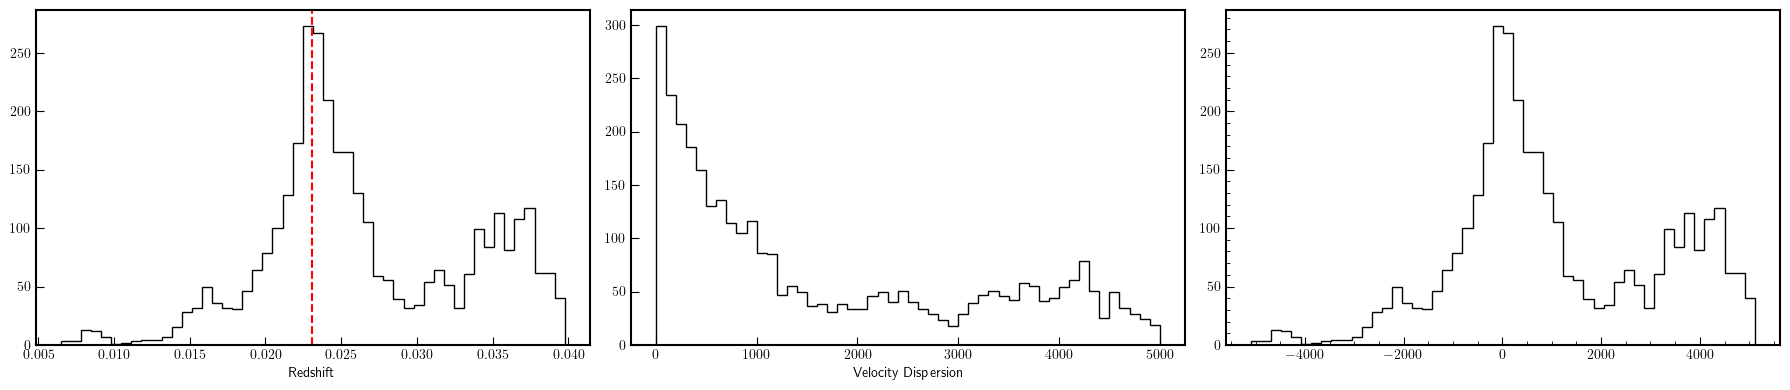

In [6]:
# Crear la figura y los subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.hist(t['z'], bins=50, fc='black', ec='black', histtype='step')
ax1.axvline(c_z, color='red', linestyle='--')
ax1.set_xlabel('Redshift')
#ax1.set_ylabel('Count')

ax2.hist(t['dV'], bins=50, fc='black', ec='black', histtype='step')
#ax2.axvline(c_z, color='red', linestyle='--')
ax2.set_xlabel('Velocity Dispersion')

ax3.hist(t['V_pec'], bins=50, fc='black', ec='black', histtype='step')
ax3.minorticks_on()

plt.tight_layout()
plt.show()


Text(0.5, 0, 'redshift')

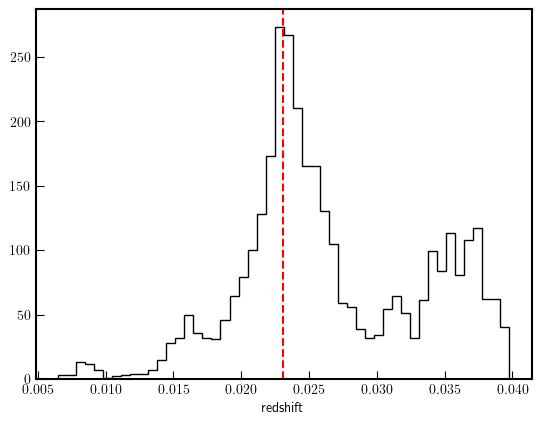

In [7]:

plt.hist(t['z'], bins=50, fc='black', ec='black', histtype='step')
plt.axvline(c_z, color='red', linestyle='--')
plt.xlabel('redshift')

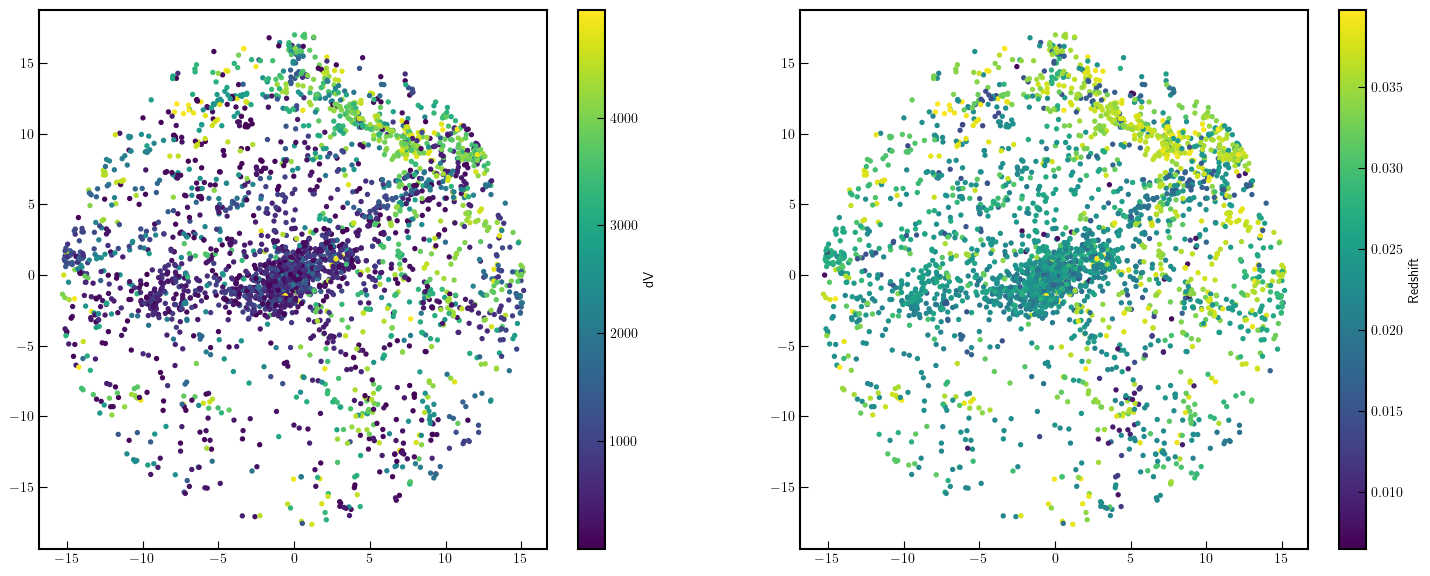

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,7)) 

sc1 = ax1.scatter(t['X_'], t['Y_'], c=t['dV'], s=8, cmap='viridis')
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('dV')

sc2 = ax2.scatter(t['X_'], t['Y_'], c=t['z'], s=8, cmap='viridis')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Redshift')
plt.show()

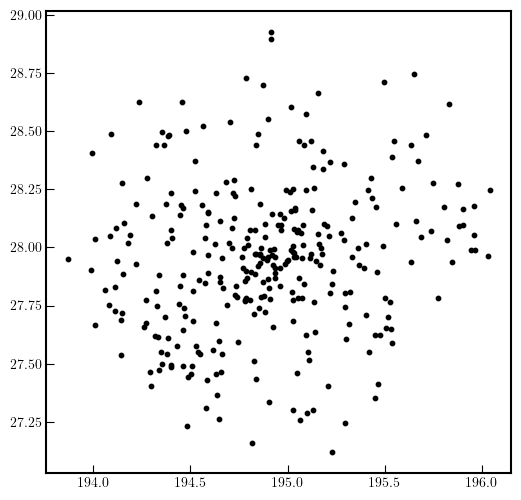

In [10]:
fig, ax = plt.subplots(figsize=(6,6)) 

ax.scatter(tc1['ra'], tc1['dec'], s=10, c='k')

#### 2) Realizar un análisis de las distintas propiedades de las galaxias miembro del cúmulo tales como:
- índice de color (Mg-Mr)
- tasa de formación estelar específica logSSFR
- parámetro de edad de poblaciones estelares dn(4000)
- índice de concentración C
- relación color-magnitud (Mg-Mr) vs Mr
#### para tres submuestras de distancia al centro del sistema.
- Region cenrtal:  rp < 0.5 Mpc
- Media:     0.5 < rp < 1.5 Mpc
- Periferia: 1.5 < rp < 2.5 Mpc
- Eterna:    2.5 < rp < 3.5 Mpc
#### En todos los casos considerar corte en diferencia de velocidad radial. Analizar los resultados y comparar con datos de la bibliografía.

In [11]:
# r interno
c_in = tc[tc['rp']<0.5]

# r medio
c_md = tc[tc['rp']>0.5]
c_md = c_md[c_md['rp']<1.5]

# r periferia
c_pe = tc[tc['rp']>1.5]
c_pe = c_pe[c_pe['rp']<2.5]

# r externo
c_ex = tc[tc['rp']>2.5]
c_ex = c_ex[c_ex['rp']<3.5]

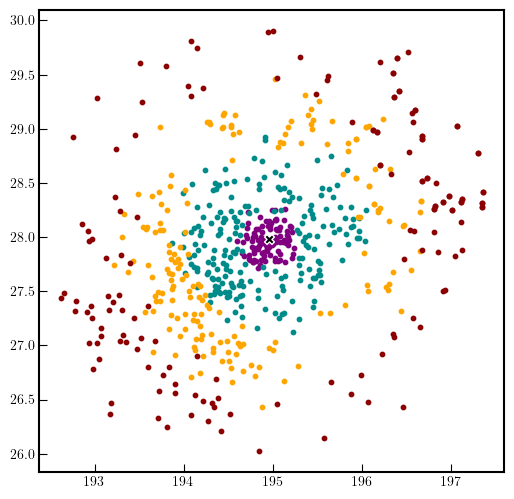

In [12]:
fig, ax = plt.subplots(figsize=(6,6)) 

ax.scatter(c_in['ra'], c_in['dec'], s=10, c='purple')
ax.scatter(c_md['ra'], c_md['dec'], s=10, c='darkcyan')
ax.scatter(c_pe['ra'], c_pe['dec'], s=10, c='orange')
ax.scatter(c_ex['ra'], c_ex['dec'], s=10, c='darkred')
ax.scatter(c_ra, c_de, s=50, ec='white', fc='black', marker='X')
#ax.add_patch(Circle((c_ra.value, c_de.value), 0.5, color='black', fc='none', linestyle='--'))

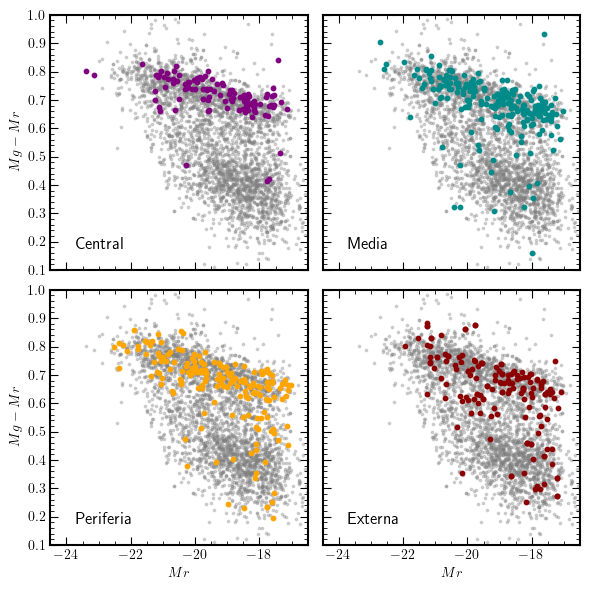

In [13]:
####### CMD

fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(6,6), sharey=True, sharex=True)

# INNER
ax1.scatter(t['Mr'], t['gr'], s=3, c='gray', alpha=0.3)
ax1.scatter(c_in['Mr'], c_in['gr'], s=10, c='purple')
ax1.set_ylabel(r'$Mg - Mr$')
ax1.text(0.1, 0.1, 'Central', transform=ax1.transAxes, ha='left', va='center', size=12)
ax1.set_ylim(0.1,1.0)
ax1.set_xlim(-24.5,-16.5)
ax1.minorticks_on()
ax1.tick_params(axis='x', which='both', top=True)
ax1.tick_params(axis='y', which='both', right=True)

# MEDIA
ax2.scatter(t['Mr'], t['gr'], s=3, c='gray', alpha=0.3)
ax2.scatter(c_md['Mr'], c_md['gr'], s=10, c='darkcyan')
ax2.text(0.1, 0.1, 'Media', transform=ax2.transAxes, ha='left', va='center', size=12)
ax2.set_ylim(0.1,1.0)
ax2.set_xlim(-24.5,-16.5)
ax2.minorticks_on()
ax2.tick_params(axis='x', which='both', top=True)
ax2.tick_params(axis='y', which='both', right=True)

# PERIFERIA
ax3.scatter(t['Mr'], t['gr'], s=3, c='gray', alpha=0.3)
ax3.scatter(c_pe['Mr'], c_pe['gr'], s=10, c='orange')
ax3.text(0.1, 0.1, 'Periferia', transform=ax3.transAxes, ha='left', va='center', size=12)
ax3.set_ylim(0.1,1.0)
ax3.set_xlim(-24.5,-16.5)
ax3.set_ylabel(r'$Mg - Mr$')
ax3.set_xlabel(r'$Mr$')
ax3.minorticks_on()
ax3.tick_params(axis='x', which='both', top=True)
ax3.tick_params(axis='y', which='both', right=True)

# EXTERNO
ax4.scatter(t['Mr'], t['gr'], s=3, c='gray', alpha=0.3)
ax4.scatter(c_ex['Mr'], c_ex['gr'], s=10, c='darkred')
ax4.set_xlabel('Mr')
ax4.text(0.1, 0.1, 'Externa', transform=ax4.transAxes, ha='left', va='center', size=12)
ax4.set_ylim(0.1,1.0)
ax4.set_xlim(-24.5,-16.5)
ax4.set_xlabel(r'$Mr$')
ax4.minorticks_on()
ax4.tick_params(axis='x', which='both', top=True)
ax4.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()


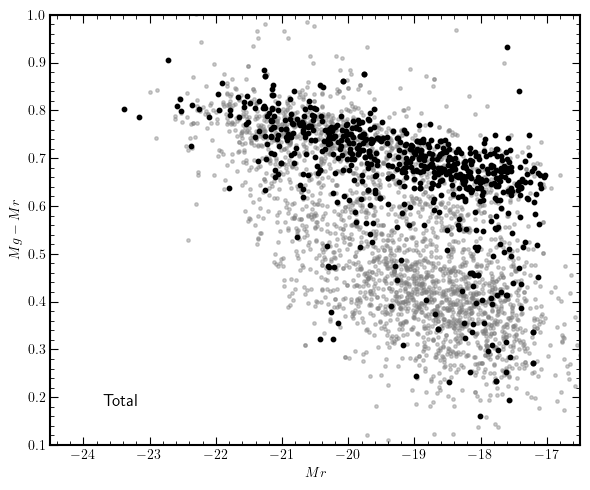

In [14]:
fig, ax = plt.subplots(figsize=(6,5))

# Fourth subplot spanning three columns
ax.scatter(t['Mr'], t['gr'], s=6, c='gray', alpha=0.4)
ax.scatter(tc['Mr'], tc['gr'], s=10, c='black')
ax.set_xlabel(r'$Mr$')
ax.set_ylabel(r'$Mg-Mr$')
ax.text(0.1, 0.1, 'Total', transform=ax.transAxes, ha='left', va='center', size=12)
ax.set_ylim(0.1,1.0)
ax.set_xlim(-24.5,-16.5)
ax.set_ylabel(r'$Mg - Mr$')
ax.set_xlabel(r'$Mr$')
ax.minorticks_on()
ax.tick_params(axis='x', which='both', top=True)
ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()


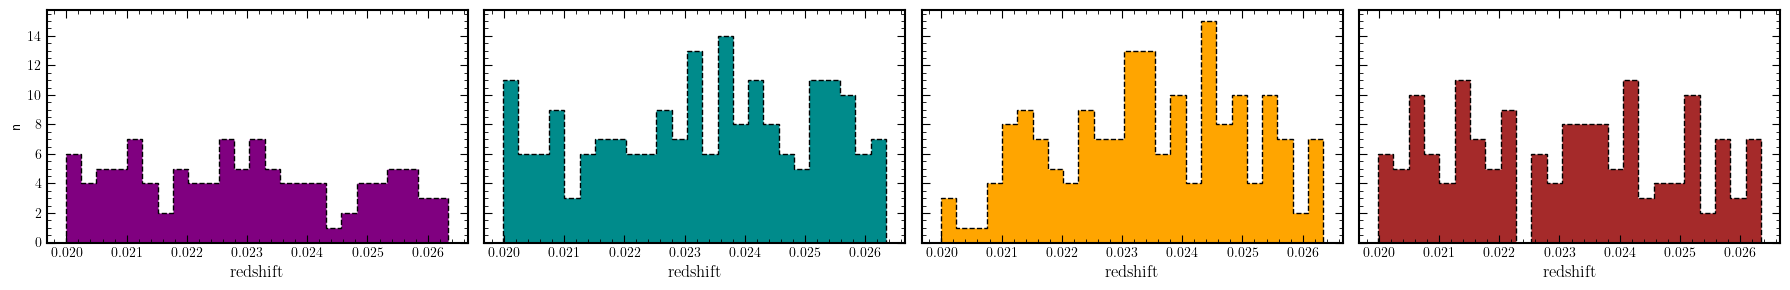

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['z'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\mathrm{redshift}$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

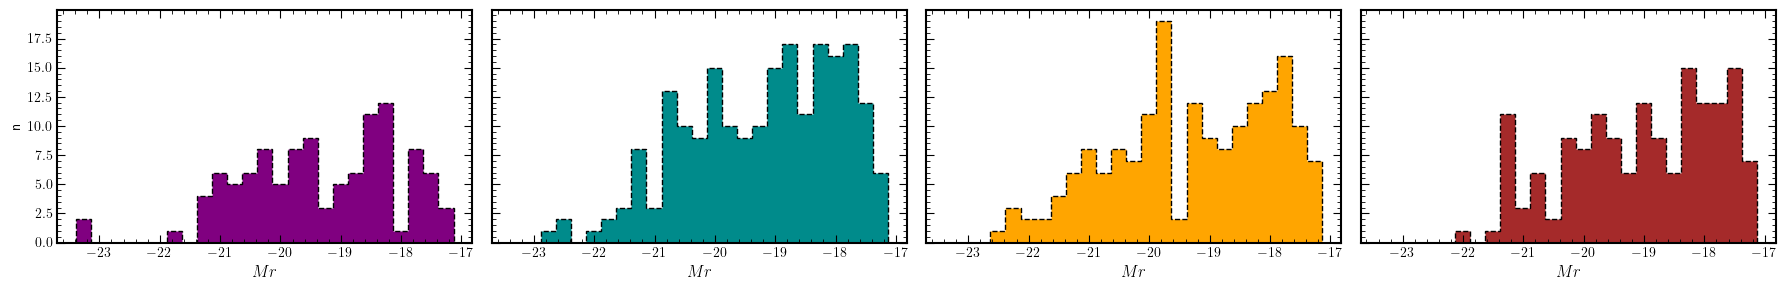

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['Mr'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$Mr$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

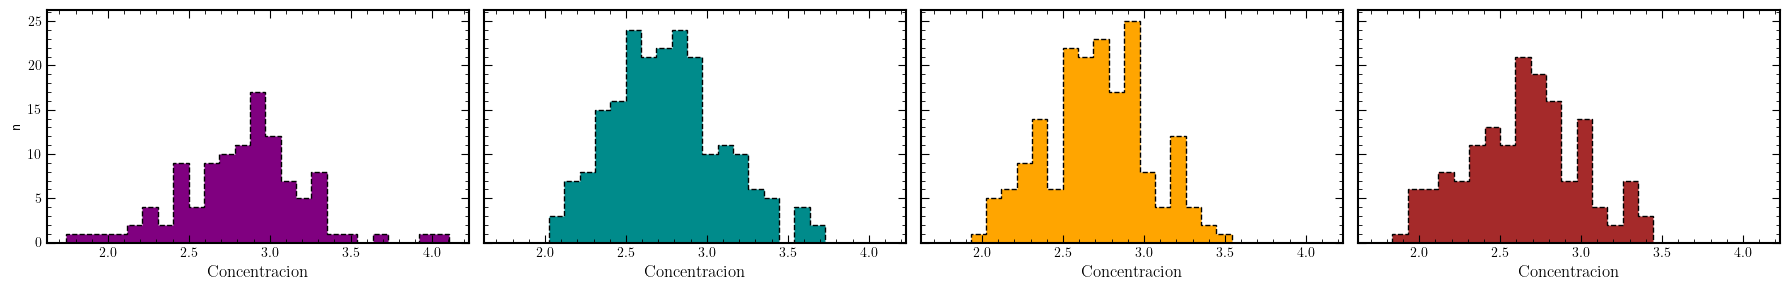

In [68]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['C'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\mathrm{Concentracion}$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

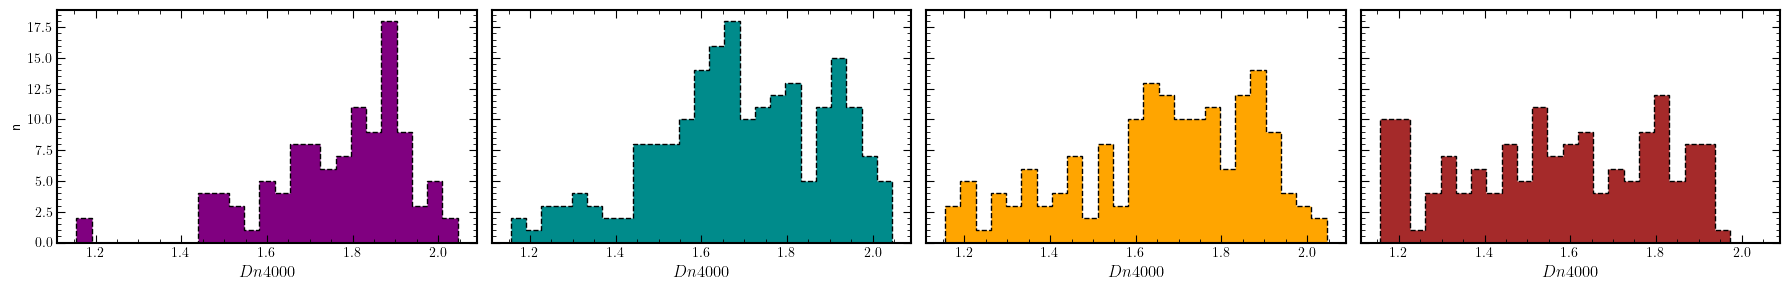

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['dn4000'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$Dn4000$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

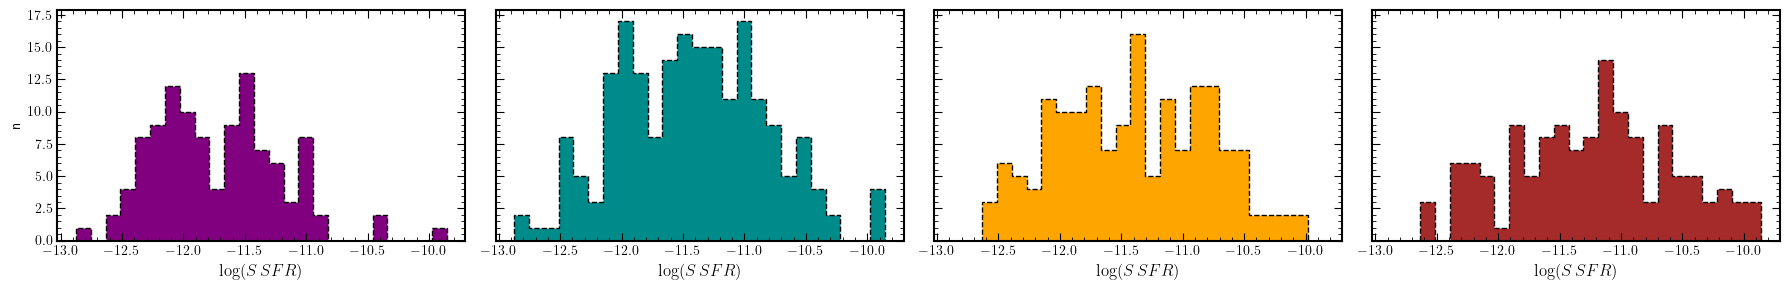

In [65]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['logSSFR'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\log(S\,SFR)$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

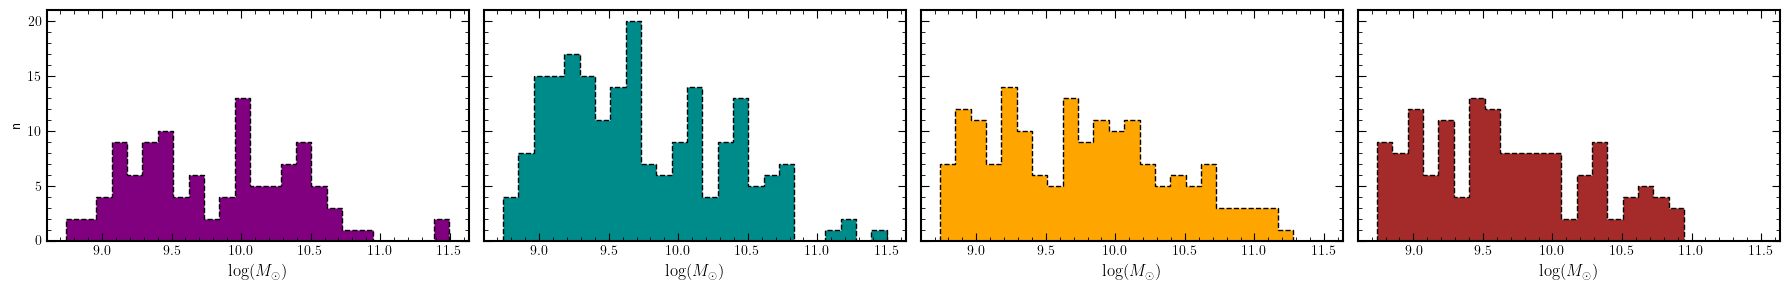

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

#tables = [c_in, c_md, c_pe, c_ex]
#colors = ['purple', 'darkcyan', 'orange', 'brown']
bins = 25

for i, (ax, table, color) in enumerate(zip(axes, tables, colors)):
    hist = ax.hist(table['logSM'], bins=bins, fc=color, ec='black', histtype='stepfilled', linestyle='--')
    bins = hist[1]  # Use the bins from the first histogram for subsequent histograms
    ax.set_xlabel(r'$\log(M_{\odot})$', size=12)
    if i == 0:
        ax.set_ylabel(r'n')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

plt.tight_layout()
plt.show()

Text(0.5, 0, '$\\log(M_{\\odot})$')

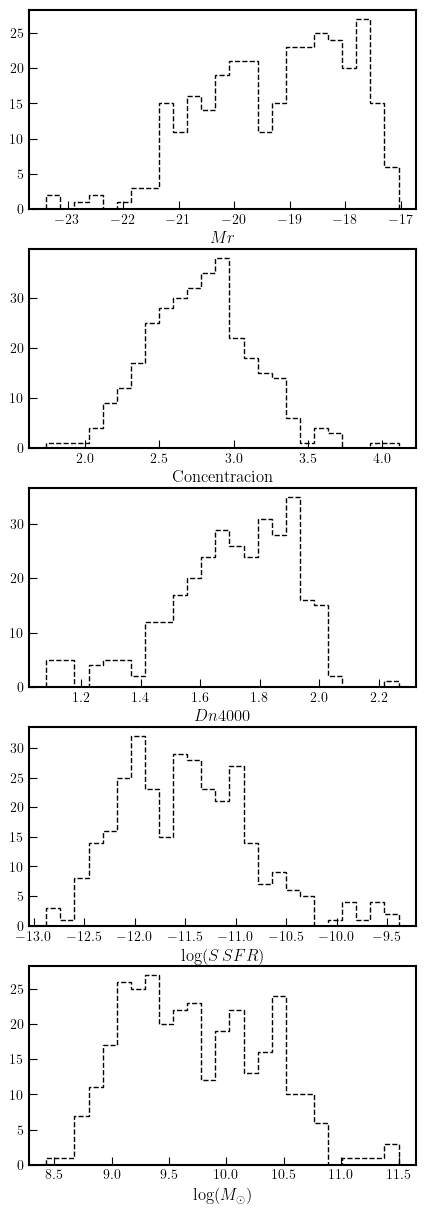

In [76]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(5,15))

h1 = ax1.hist(tc1['Mr'], bins=25, ec='black', histtype='step', linestyle='--')
ax1.set_xlabel(r'$Mr$', size=12)

h2 = ax2.hist(tc1['C'], bins=25, ec='black', histtype='step', linestyle='--')
ax2.set_xlabel(r'$\mathrm{Concentracion}$', size=12)

h3 = ax3.hist(tc1['dn4000'], bins=25, ec='black', histtype='step', linestyle='--')
ax3.set_xlabel(r'$Dn4000$', size=12)

h4 = ax4.hist(tc1['logSSFR'], bins=25, ec='black', histtype='step', linestyle='--')
ax4.set_xlabel(r'$\log(S\,SFR)$', size=12)

h5 = ax5.hist(tc1['logSM'], bins=25, ec='black', histtype='step', linestyle='--')
ax5.set_xlabel(r'$\log(M_{\odot})$', size=12)

#h21 = ax2.hist(c_in['C'], bins=25, fc='purple', histtype='stepfilled', linestyle='--')
#h22 = ax2.hist(c_md['C'], bins=h21[1], fc='darkcyan', histtype='stepfilled', linestyle='--', bottom=h21[0])
#h23 = ax2.hist(c_pe['C'], bins=h22[1], fc='orange', histtype='stepfilled', linestyle='--', bottom=h21[0]+h22[0])
#h24 = ax2.hist(c_ex['C'], bins=h23[1], fc='darkred', histtype='stepfilled', linestyle='--', bottom=h21[0]+h22[0]+h23[0])
#ax2.set_xlabel(r'$\mathrm{Concentracion}$', size=12)

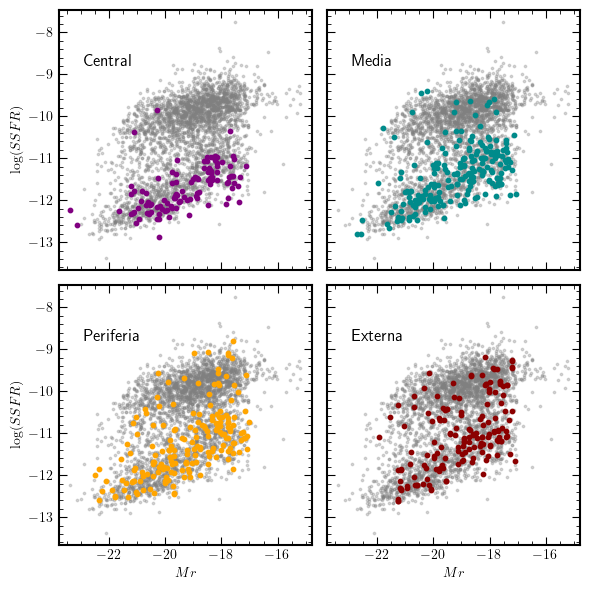

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'darkred']
labels = ['Central', 'Media', 'Periferia', 'Externa']

for ax, table, color, label in zip(axes.flat, tables, colors, labels):
    ax.scatter(t['Mr'], t['logSSFR'], s=3, c='gray', alpha=0.3)
    ax.scatter(table['Mr'], table['logSSFR'], s=10, c=color)
    ax.text(0.1, 0.8, label, transform=ax.transAxes, ha='left', va='center', size=12)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)

# Set specific labels for y-axis and x-axis where needed
axes[0, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_xlabel(r'$Mr$')
axes[1, 1].set_xlabel(r'$Mr$')

plt.tight_layout()
plt.show()

Text(0.5, 0, '$\\log(M_{\\odot})$')

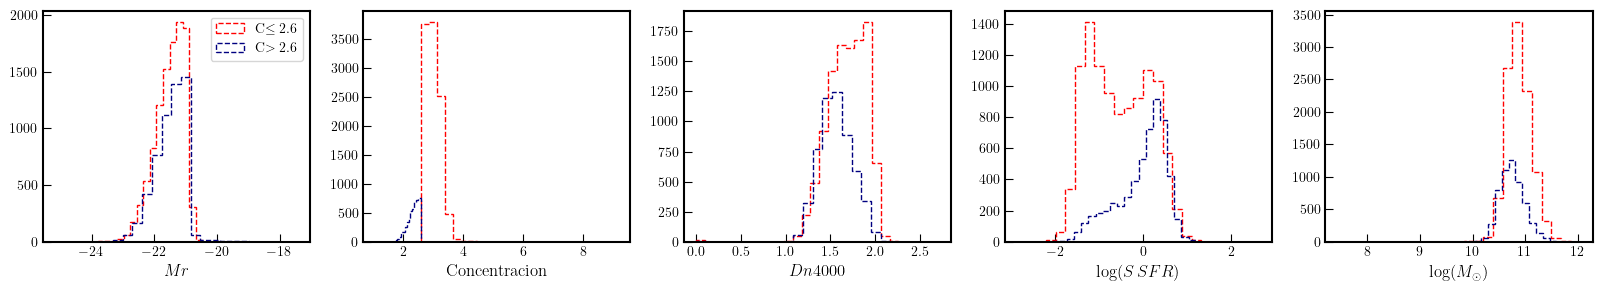

In [141]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,3))

h11 = ax1.hist(vds1_e['Mr'], bins=25, color='red', histtype='step', linestyle='--', label=r'C$\leq 2.6$')
h12 = ax1.hist(vds1_l['Mr'], bins=25, color='navy', histtype='step', linestyle='--', label=r'C$>2.6$')
#h12 = ax1.hist(vds2['Mr'], bins=25, ec='black', histtype='step', linestyle='--')
ax1.set_xlabel(r'$Mr$', size=12)
ax1.legend()

h21 = ax2.hist(vds1_e['concind'], bins=25, color='red', histtype='step', linestyle='--')
h22 = ax2.hist(vds1_l['concind'], bins=25, color='navy', histtype='step', linestyle='--')
#h2 = ax2.hist(vds2['concind'], bins=25, ec='black', histtype='step', linestyle='--')
ax2.set_xlabel(r'$\mathrm{Concentracion}$', size=12)

h31 = ax3.hist(vds1_e['dn4000'], bins=25, color='red', histtype='step', linestyle='--')
h32 = ax3.hist(vds1_l['dn4000'], bins=25, color='navy', histtype='step', linestyle='--')
#h3 = ax3.hist(vds2['dn4000'], bins=25, ec='black', histtype='step', linestyle='--')
ax3.set_xlabel(r'$Dn4000$', size=12)

h41 = ax4.hist(vds1_e['sfr'], bins=25, color='red', histtype='step', linestyle='--')
h42 = ax4.hist(vds1_l['sfr'], bins=25, color='navy', histtype='step', linestyle='--')
#h4 = ax4.hist(vds2_l['sfr'], bins=25, color='navy', histtype='step', linestyle='--')
ax4.set_xlabel(r'$\log(S\,SFR)$', size=12)

h51 = ax5.hist(vds1_e['stmass'], bins=25, color='red', histtype='step', linestyle='--')
h52 = ax5.hist(vds1_l['stmass'], bins=25, color='navy', histtype='step', linestyle='--')
#h5 = ax5.hist(vds2['stmass'], bins=25, ec='black', histtype='step', linestyle='--')
ax5.set_xlabel(r'$\log(M_{\odot})$', size=12)

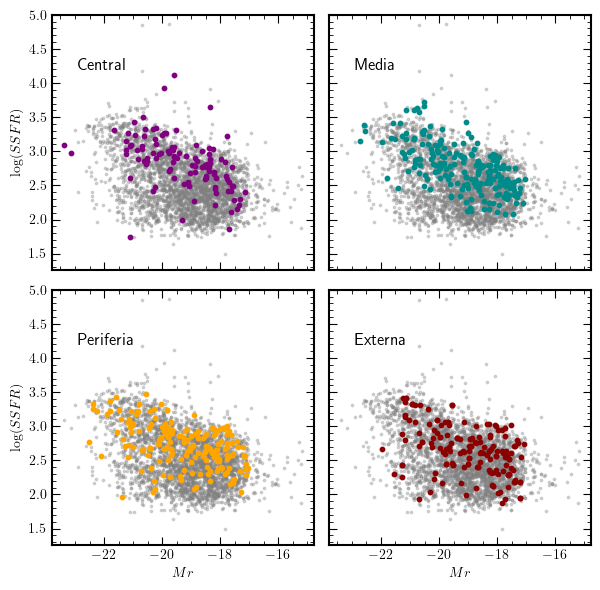

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)

tables = [c_in, c_md, c_pe, c_ex]
colors = ['purple', 'darkcyan', 'orange', 'darkred']
labels = ['Central', 'Media', 'Periferia', 'Externa']

for ax, table, color, label in zip(axes.flat, tables, colors, labels):
    ax.scatter(t['Mr'], t['C'], s=3, c='gray', alpha=0.3)
    ax.scatter(table['Mr'], table['C'], s=10, c=color)
    ax.text(0.1, 0.8, label, transform=ax.transAxes, ha='left', va='center', size=12)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='both', top=True)
    ax.tick_params(axis='y', which='both', right=True)
    ax.set_ylim(top=5)

# Set specific labels for y-axis and x-axis where needed
axes[0, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_ylabel(r'$\log (S SFR)$')
axes[1, 0].set_xlabel(r'$Mr$')
axes[1, 1].set_xlabel(r'$Mr$')

plt.tight_layout()
plt.show()

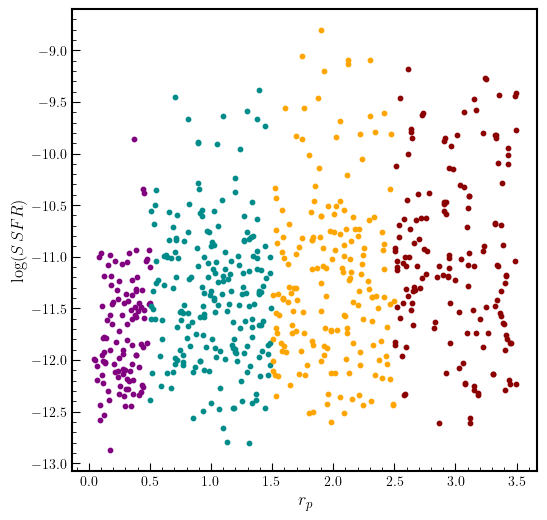

In [82]:
fig, ax = plt.subplots(figsize=(6,6)) 

ax.scatter(c_in['rp'], c_in['logSSFR'], s=10, c='purple')
ax.scatter(c_md['rp'], c_md['logSSFR'], s=10, c='darkcyan')
ax.scatter(c_pe['rp'], c_pe['logSSFR'], s=10, c='orange')
ax.scatter(c_ex['rp'], c_ex['logSSFR'], s=10, c='darkred')
ax.set_xlabel(r'$r_p$', size=13)
ax.set_ylabel(r'$\log(S\,SFR)$', size=12)
ax.minorticks_on()